In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch
import torch.nn as nn
# import torch.optim as optim
# import torchvision
# from ray import tune
from torch.utils.data import DataLoader, TensorDataset #, Dataset
# import torch.nn.functional as F

import wandb
import os
from sklearn.decomposition import PCA
import GPUtil
import itertools
import io

from collections import Counter
import random
from sklearn.metrics import confusion_matrix as cm

# Loading Data:
---

In [ ]:
file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/train_data.csv'
train = pd.read_csv(file_path)
file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/val_data.csv'
val = pd.read_csv(file_path)
file_path = '/mnt/usb/cmdunham/preprocessed_ims_data/test_data.csv'
test = pd.read_csv(file_path)

In [28]:
file_path = '../data/name_smiles_embedding_file.csv'
name_smiles_embedding_df = pd.read_csv(file_path)

In [29]:
train.head()

,Unnamed: 0,index,p_184,p_185,p_186,p_187,p_188,p_189,p_190,p_191,...,n_1021,Label,DEB,DEM,DMMP,DPM,DtBP,JP8,MES,TEPO
0,272149,1297539,94.0,96.0,99.0,101.0,105.0,109.0,115.0,120.0,...,-5.0,DtBP,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,293336,1344903,108.0,112.0,117.0,122.0,128.0,133.0,138.0,145.0,...,-4.0,DMMP,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,240982,1221071,116.0,122.0,130.0,135.0,143.0,150.0,159.0,167.0,...,3.0,TEPO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,226406,1173350,95.0,101.0,106.0,112.0,119.0,124.0,128.0,132.0,...,-3.0,DtBP,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,311847,1416666,105.0,109.0,114.0,119.0,125.0,131.0,138.0,143.0,...,-20.0,TEPO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [30]:
train.columns[-8:]

Index(['DEB', 'DEM', 'DMMP', 'DPM', 'DtBP', 'JP8', 'MES', 'TEPO'], dtype='object')

In [31]:
name_smiles_embedding_df.head()

,Unnamed: 0,Name,SMILES,embedding
0,BKG,background,NaN,NaN
1,DEM,Diethyl Malonate,CCOC(=O)CC(=O)OCC,"[0.3809721, 0.0005454041, 0.25539744, -0.24272..."
2,DEB,"1,2,3,4-Diepoxybutane",C1C(O1)C2CO2,"[0.06318794, 0.009022224, 0.42160064, 0.195722..."
3,MES,2-(N-morpholino)ethanesulfonic acid,C1COCCN1CCS(=O)(=O)O,"[-0.32520828, 0.009838344, -0.15108332, 0.2845..."
4,DMMP,Dimethyl methylphosphonate,COP(=O)(C)OC,"[0.12106811, 0.00294244, -0.14450458, 0.072665..."


# Definitions:
---

In [32]:
def flatten_and_bin(predicted_embeddings_batches):
    # Function to flatten the list of prediction batches and make each prediction binary
    binary_preds_list = []
    
    for batch in predicted_embeddings_batches:
        for encoding in batch:
            # Get the index of the maximum value
            max_index = torch.argmax(encoding)
            # Create a binary label with 1 in the index of the highest value's index in the encoding 0s in all other indices
            binary_pred = [0] * len(encoding)
            binary_pred[max_index] = 1
            binary_preds_list.append(binary_pred)
    
    return binary_preds_list

In [33]:
def run_with_wandb(config, **kwargs):
    config.update(kwargs)

    wandb.init(entity=config['wandb_entity'],
               project=config['wandb_project'],
               config=config)

    # Set the number of threads
    torch.set_num_threads(config['threads'])

    # Find out is there is a GPU available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if not config['gpu']:
        device = torch.device('cpu')
    print(f'Using device: {device}')

In [34]:
def update_wandb_kwargs(wandb_kwargs, updates):
    for key in updates.keys():
        wandb_kwargs[key] = updates[key]
    return wandb_kwargs

In [35]:
def train_one_epoch(train_dataset, device, model, criterion, optimizer, epoch, combo):
  epoch_training_loss = 0

  predicted_embeddings = []
  output_name_encodings = []

  for batch, name_encodings, true_embeddings, _ in train_dataset:
    # move inputs to device
    batch = batch.to(device)
    name_encodings = name_encodings.to(device)
    true_embeddings = true_embeddings.to(device)

    # backprapogation
    optimizer.zero_grad()

    # forward pass
    batch_predicted_embeddings = model(batch)

    loss = criterion(batch_predicted_embeddings, true_embeddings)
    # accumulate epoch training loss
    epoch_training_loss += loss.item()

    loss.backward()
    optimizer.step()

    # at last epoch store output embeddings and corresponding labels to output list
    if (epoch + 1) == combo['epochs']:
      output_name_encodings.append(name_encodings)
      predicted_embeddings.append(batch_predicted_embeddings)

  # divide by number of batches to calculate average loss
  average_loss = epoch_training_loss/len(train_dataset)
  if (epoch + 1) == combo['epochs']:
    return average_loss, predicted_embeddings, output_name_encodings
  else:
    return average_loss

In [36]:
def preds_to_emb_pca_plot(
        predicted_embeddings, output_name_encodings, 
        sorted_chem_names, emb_df, 
        mass_spec_encoder_embeddings=False, mass_spec_chems=False
        ):
    """
    Generate and plot a PCA visualization of predicted embeddings against corresponding ChemNet embeddings.

    Parameters:
    ----------
    predicted_embeddings : list of list of torch.Tensor
        A nested list of predicted embeddings, where each inner list contains tensors for a batch.

    output_name_encodings : list of list of torch.Tensor
        A nested list of one-hot encoded tensors representing the chemical names for the predicted embeddings.

    sorted_chem_names : list of str
        A list of chemical names corresponding to the indices of the one-hot encodings.

    emb_df : pandas.DataFrame
        A DataFrame containing true embeddings, with 'Embedding Floats' as one of its columns.

    log_wandb : boolean 
        True - log plot to wandb. False - do not log plot to wandb.

    Returns:
    -------
    A tuple containing:
    - true_embeddings (pd.DataFrame): DataFrame of true embeddings used for comparison.
    - predicted_embeddings_flattened (list): Flattened list of predicted embeddings.
    - chem_names (list): List of chemical names corresponding to the predicted embeddings.
    """

    # Currently, preds and name encodings are lists of [n_batches, batch_size], flattening to lists of [n_samples]
    predicted_embeddings_flattened = [emb.cpu().detach().numpy() for emb_list in predicted_embeddings for emb in emb_list]
    chem_name_encodings_flattened = [enc.cpu() for enc_list in output_name_encodings for enc in enc_list]

    # Get chemical names from encodings
    chem_names = [sorted_chem_names[list(encoding).index(1)] for encoding in chem_name_encodings_flattened]

    if mass_spec_encoder_embeddings:
        for emb in mass_spec_encoder_embeddings:
            predicted_embeddings_flattened.append(torch.Tensor(emb))
        chem_names += mass_spec_chems

    try:
        # making list of all embeddings and chem names except for BKG
        embeddings = [emb for emb in emb_df['Embedding Floats']][1:]
        cols = emb_df.index[1:]
        true_embeddings = pd.DataFrame(embeddings).T
        true_embeddings.columns = cols
        
    except KeyError as e:
        if str(e) == "'Embedding Floats'":
            true_embeddings = emb_df
    
    return (true_embeddings, predicted_embeddings_flattened, chem_names)

In [37]:
def predict_embeddings(dataset, model, device, criterion):
    total_loss = 0

    model.eval() # Set model to evaluation mode
    predicted_embeddings = []
    output_name_encodings = []
    input_spectra_indices = []

    with torch.no_grad():
        for batch, name_encodings, true_embeddings, spectra_indices in dataset:
            batch = batch.to(device)
            true_embeddings = true_embeddings.to(device)

            batch_predicted_embeddings = model(batch)
            predicted_embeddings.append(batch_predicted_embeddings)
            output_name_encodings.append(name_encodings)
            input_spectra_indices.append(spectra_indices)

            # print(batch_predicted_embeddings.shape, true_embeddings.shape)

            loss = criterion(batch_predicted_embeddings, true_embeddings)
            # accumulate loss
            total_loss += loss.item()

    # divide by number of batches to calculate average loss
    average_loss = total_loss/len(dataset)
    return predicted_embeddings, output_name_encodings, average_loss, input_spectra_indices

In [38]:
def plot_emb_pca(
        all_embeddings, ims_embeddings, output_type, embedding_type=None, mass_spec_embeddings = None, log_wandb=False, 
        chemnet_embeddings_to_plot=None, mse_insert=None, insert_position=[0.05, 0.05]):
    """
    Perform PCA on chemical embeddings and plot the transformed data, including IMS and Mass Spec embeddings if provided.

    Parameters:
    ----------
    all_embeddings : pd.DataFrame
        A dataframe containing ChemNet embeddings for all chemicals. 
        Each column represents one chemical's ChemNet embedding.
    ims_embeddings : pd.DataFrame
        A dataframe containing IMS (ion mobility spectrometry) embeddings. Must include a 'Label' column
        with chemical names and additional columns for embedding features.
    mass_spec_embeddings : pd.DataFrame, optional
        A dataframe containing mass spectrometry embeddings. Similar structure to `ims_embeddings`.
        Default is None, meaning mass spec embeddings are not included.
    log_wandb : bool, optional
        If True, logs the generated plot to Weights and Biases (wandb). Default is True.
    chemnet_embeddings_to_plot : pd.DataFrame, optional
        A dataframe containing ChemNet embeddings for all chemicals TO BE PLOTTED. 
        Each column represents one chemical's ChemNet embedding.

    Returns:
    -------
    None
        Displays the PCA scatter plot with ChemNet, IMS, and Mass Spec embeddings. 
        Optionally logs the plot to wandb if `log_wandb` is True.

    Notes:
    -----
    - PCA is performed on the transpose of `all_embeddings` so that embeddings for ims and mass spec data can be plotted to the same space.
    """ 
    pca = PCA(n_components=2)
    pca.fit(all_embeddings.T)

    if chemnet_embeddings_to_plot is not None:
        transformed_embeddings = pca.transform(chemnet_embeddings_to_plot.T)
        all_chemical_names = list(chemnet_embeddings_to_plot.columns)
    else:
        transformed_embeddings = pca.transform(all_embeddings.T) 
        all_chemical_names = list(all_embeddings.columns)

    _, ax = plt.subplots(figsize=(8,6))

    # Create a color cycle for distinct colors
    color_cycle = plt.gca()._get_lines.prop_cycler

    ims_labels = list(ims_embeddings['Label'])
    if mass_spec_embeddings is not None:
        mass_spec_labels=list(mass_spec_embeddings['Label'])
    else:
        mass_spec_labels = False
    
    # Scatter plot
    for chem in all_chemical_names:
        idx = all_chemical_names.index(chem)
        color = next(color_cycle)['color']
        # only label 1st 8 chemicals to avoid giant legend
        # ax.scatter(0,0, color = color, label=chem)
        if idx < 8:
            ax.scatter(transformed_embeddings[idx, 0], transformed_embeddings[idx, 1], color = color, label=chem)#, s=200)
        else:
            ax.scatter(transformed_embeddings[idx, 0], transformed_embeddings[idx, 1], color = color)#, s=75)
        # Transform ims_embeddings for the current chemical, if we have ims data for chem
        if chem in ims_labels:
            # transform all data for the given chemical. Exclude last col (label)
            ims_transformed = pca.transform(ims_embeddings[ims_embeddings['Label'] == chem].iloc[:, :-1])
            
            # Scatter plot for ims_embeddings with a different marker
            ax.scatter(ims_transformed[:, 0], ims_transformed[:, 1], marker='o', facecolors='none', edgecolors=color)#marker='x', color=color)#, s=75)
        # repeat for mass spec
        if mass_spec_labels:
            if chem in mass_spec_labels:
                # transform all data for the given chemical. Exclude last col (label)
                mass_spec_transformed = pca.transform(mass_spec_embeddings[mass_spec_embeddings['Label'] == chem].iloc[:, :-1].values)
                
                # Scatter plot for mass_spec_embeddings with a different marker
                ax.scatter(mass_spec_transformed[:, 0], mass_spec_transformed[:, 1], marker='*', color=color, s=75)
    # Add legend
    legend1 = ax.legend(loc='upper right', title='Label')
    ax.add_artist(legend1)

    marker_legends = [
    plt.Line2D([0], [0], marker='o', color='w', label=embedding_type, markerfacecolor='black', markersize=6),
    plt.Line2D([0], [0], marker='o', color='w', label="IMS", markerfacecolor='none', markeredgecolor='black', markersize=6),
    ]
    
    if mass_spec_embeddings is not None:
        marker_legends.append(plt.Line2D([0], [0], marker='*', color='w', label='Mass Spec', markerfacecolor='black', markersize=10))

    # Add the second legend
    legend2 = ax.legend(handles=marker_legends, title='Marker Types', loc='upper left')
    ax.add_artist(legend2)

    if mse_insert is not None:
        # Add mse text in the corner with a box
        plt.text(insert_position[0], insert_position[1], f'MSE: {format(mse_insert, ".2e")}', 
            transform=plt.gca().transAxes,  # Use axis coordinates
            fontsize=14,
            verticalalignment='bottom',  # Align text to the top
            horizontalalignment='left',  # Align text to the right
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))  # Box properties

    plt.xticks([])
    plt.yticks([])
    if embedding_type is not None:
        plt.title(f'{embedding_type} vs. Encoder {output_type} Output PCA', fontsize=18)
    else:
        plt.title(f'ChemNet vs. Encoder {output_type} Output PCA', fontsize=18)

    if log_wandb:
        plt.savefig('tmp_plot.png', format='png', dpi=300)
        wandb.log({'PCA of Predicted Chemical Embeddings': wandb.Image('tmp_plot.png')})

    plt.show()

In [39]:
def plot_pca(
    data, batch_size, model, device, encoder_criterion, sorted_chem_names, 
    all_embeddings_df, ims_embeddings_df, 
    output_type, log_wandb=True, embedding_type='ChemNet'
    ):
    dataset = DataLoader(
        data, 
        batch_size=batch_size, 
        shuffle=False
    )

    preds, name_encodings, avg_loss, _ = predict_embeddings(dataset, model, device, encoder_criterion)
    true_embeddings, predicted_embeddings_flattened, chem_names = preds_to_emb_pca_plot(
        preds, name_encodings, sorted_chem_names, ims_embeddings_df,  
        )
    preds_df = pd.DataFrame(predicted_embeddings_flattened)
    preds_df['Label'] = chem_names
    
    plot_emb_pca(
        all_embeddings_df, preds_df, output_type=output_type, 
        embedding_type=embedding_type, log_wandb=log_wandb, 
        chemnet_embeddings_to_plot=true_embeddings, mse_insert=avg_loss,
        )

In [40]:
def train_model(
        encoder, train_data, val_data, test_data, device, config, wandb_kwargs, all_embeddings_df, ims_embeddings_df,
        model_hyperparams, sorted_chem_names, encoder_path, save_emb_pca_to_wandb = True, early_stop_threshold=10, embedding_type='ChemNet'
        ):

    # loss to compare for each model. Starting at infinity so it will be replaced by first model's first epoch loss 
    lowest_val_loss = np.inf

    keys = model_hyperparams.keys()
    values = model_hyperparams.values()

    # Generate all parameter combinations from model_config using itertools.product
    combinations = itertools.product(*values)

    # Iterate through each parameter combination and run model 
    for combo in combinations:
        epochs_without_validation_improvement = 0
        combo = dict(zip(keys, combo))

        train_dataset = DataLoader(train_data, batch_size=combo['batch_size'], shuffle=True)
        val_dataset = DataLoader(val_data, batch_size=combo['batch_size'], shuffle=False)

        encoder_optimizer = torch.optim.AdamW(encoder.parameters(), lr = combo['learning_rate'])
        encoder_criterion = nn.MSELoss()

        wandb_kwargs = update_wandb_kwargs(wandb_kwargs, combo)

        run_with_wandb(config, **wandb_kwargs)

        print('--------------------------')
        print('--------------------------')
        print('New run with hyperparameters:')
        for key in combo:
            print(key, ' : ', combo[key])

        for epoch in range(combo['epochs']):
            if epochs_without_validation_improvement < early_stop_threshold:
                encoder.train(True)

                # do a pass over the data
                # at last epoch get predicted embeddings and chem names
                if (epoch + 1) == combo['epochs']:
                    average_loss, _, _ = train_one_epoch(
                    train_dataset, device, encoder, encoder_criterion, encoder_optimizer, epoch, combo
                    )
                    # save output pca to weights and biases
                    if save_emb_pca_to_wandb:
                        # plot_pca gets predictions from trained model and plots them
                        plot_pca(
                            train_data, combo['batch_size'], encoder, device, 
                            encoder_criterion, sorted_chem_names, all_embeddings_df, 
                            ims_embeddings_df, 'Train', embedding_type
                            )
                        plot_pca(
                            test_data, combo['batch_size'], encoder, device, 
                            encoder_criterion, sorted_chem_names, all_embeddings_df,
                            ims_embeddings_df, 'Test', embedding_type)
                else:
                    average_loss = train_one_epoch(
                    train_dataset, device, encoder, encoder_criterion, encoder_optimizer, epoch, combo
                    )

                epoch_val_loss = 0  
                # evaluate model on validation data
                encoder.eval() # Set model to evaluation mode
                with torch.no_grad():
                    for val_batch, val_name_encodings, val_true_embeddings, _ in val_dataset:
                        val_batch = val_batch.to(device)
                        val_name_encodings = val_name_encodings.to(device)
                        val_true_embeddings = val_true_embeddings.to(device)

                        val_batch_predicted_embeddings = encoder(val_batch)

                        val_loss = encoder_criterion(val_batch_predicted_embeddings, val_true_embeddings)
                        # accumulate epoch validation loss
                        epoch_val_loss += val_loss.item()

                # divide by number of batches to calculate average loss
                val_average_loss = epoch_val_loss/len(val_dataset)

                if val_average_loss < lowest_val_loss:
                    lowest_val_loss = val_average_loss
                    best_epoch = epoch + 1  # Store the best epoch
                    # Save the model state
                    torch.save(encoder.state_dict(), encoder_path)
                    best_hyperparams = combo
                    print(f'Saved best model at epoch {best_epoch}')
                    epochs_without_validation_improvement = 0
                
                else:
                    epochs_without_validation_improvement += 1
                # log losses to wandb
                wandb.log({"Encoder Training Loss": average_loss, "Encoder Validation Loss": val_average_loss})

                if (epoch + 1) % 10 == 0:
                    print('Epoch[{}/{}]:'.format(epoch+1, combo['epochs']))
                    print(f'   Training loss: {average_loss}')
                    print(f'   Validation loss: {val_average_loss}')
                    print('-------------------------------------------')
            else:
                print(f'Validation loss has not improved in {epochs_without_validation_improvement} epochs. Stopping training at epoch {epoch}.')
                plot_pca(
                    train_data, combo['batch_size'], encoder, device, 
                    encoder_criterion, sorted_chem_names, all_embeddings_df, 
                    ims_embeddings_df, 'Train', embedding_type
                    )
                plot_pca(
                    test_data, combo['batch_size'], encoder, device, 
                    encoder_criterion, sorted_chem_names, all_embeddings_df,
                    ims_embeddings_df, 'Test', embedding_type
                    )
                break
        # if save_emb_pca_to_wandb:
        #     # true_embeddings, predicted_embeddings_flattened, chem_names = 
        #     preds_to_emb_pca_plot(predicted_embeddings, output_name_encodings, sorted_chem_names, embedding_df)

        # at last epoch print model architecture details (this will also show up in wandb log)
        print('-------------------------------------------')
        print('-------------------------------------------')
        print('Dataset: ', wandb_kwargs['dataset'])
        print('Target Embeddings: ', wandb_kwargs['target_embedding'])
        print('-------------------------------------------')
        print('-------------------------------------------')
        print(encoder)
        print('-------------------------------------------')
        print('-------------------------------------------')

        wandb.finish()

    print('Hyperparameters for best model: ')
    for key in best_hyperparams:
        print('   ', key, ' : ', best_hyperparams[key])
    
    return best_hyperparams


In [41]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
      nn.Linear(1676,1548),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1548,1420),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1420, 1292),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1292, 1164),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1164, 1036),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1036, 908),
      nn.LeakyReLU(inplace=True),
      nn.Linear(908, 780),
      nn.LeakyReLU(inplace=True),
      nn.Linear(780, 652),
      nn.LeakyReLU(inplace=True),
      nn.Linear(652, 512),
    )

  def forward(self, x):
    x = self.encoder(x)
    return x

In [42]:
class IMStoOneHotEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
      nn.Linear(1676,1491),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1491,1306),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1306, 1121),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1121, 936),
      nn.LeakyReLU(inplace=True),
      nn.Linear(936, 751),
      nn.LeakyReLU(inplace=True),
      nn.Linear(751, 566),
      nn.LeakyReLU(inplace=True),
      nn.Linear(566, 381),
      nn.LeakyReLU(inplace=True),
      nn.Linear(381, 196),
      nn.LeakyReLU(inplace=True),
      nn.Linear(196, 8),
      # nn.Softmax(dim=1),
    )

  def forward(self, x):
    x = self.encoder(x)
    return x

In [43]:
# Encoder for truncated dataset
class TruncatedEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
      nn.Linear(1032,968),
      nn.LeakyReLU(inplace=True),
      nn.Linear(968,904),
      nn.LeakyReLU(inplace=True),
      nn.Linear(904, 840),
      nn.LeakyReLU(inplace=True),
      nn.Linear(840, 776),
      nn.LeakyReLU(inplace=True),
      nn.Linear(776, 712),
      nn.LeakyReLU(inplace=True),
      nn.Linear(712, 648),
      nn.LeakyReLU(inplace=True),
      nn.Linear(648, 584),
      nn.LeakyReLU(inplace=True),
      nn.Linear(584, 512),
    )

  def forward(self, x):
    x = self.encoder(x)
    return x

In [44]:
def create_dataset_tensors(spectra_dataset, embedding_df, device, carl=False):
    # drop first two cols ('Unnamed:0' and 'index') and last 9 cols ('Label' and OneHot encodings) to get just spectra
    if carl: # carl dataset has no 'Unnamed: 0' column
        spectra = spectra_dataset.iloc[:,1:-9]
    else:
        spectra = spectra_dataset.iloc[:,2:-9]
    chem_encodings = spectra_dataset.iloc[:,-8:]

    # create tensors of spectra, true embeddings, and chemical name encodings for train and val
    chem_labels = list(spectra_dataset['Label'])
    embeddings_tensor = torch.Tensor([embedding_df['Embedding Floats'][chem_name] for chem_name in chem_labels]).to(device)
    spectra_tensor = torch.Tensor(spectra.values).to(device)
    chem_encodings_tensor = torch.Tensor(chem_encodings.values).to(device)
    spectra_indices_tensor = torch.Tensor(spectra_dataset['index']).to(device)

    return embeddings_tensor, spectra_tensor, chem_encodings_tensor, spectra_indices_tensor

# Setting up Datasets
---

## Setting up GPU:
---

In [45]:
if torch.cuda.is_available():
    # Get the list of GPUs
    gpus = GPUtil.getGPUs()

    # Find the GPU with the most free memory
    best_gpu = max(gpus, key=lambda gpu: gpu.memoryFree)

    # Print details about the selected GPU
    print(f"Selected GPU ID: {best_gpu.id}")
    print(f"  Name: {best_gpu.name}")
    print(f"  Memory Free: {best_gpu.memoryFree} MB")
    print(f"  Memory Used: {best_gpu.memoryUsed} MB")
    print(f"  GPU Load: {best_gpu.load * 100:.2f}%")

    # Set the device for later use
    device = torch.device(f'cuda:{best_gpu.id}')
    print('Current device ID: ', device)

    # Set the current device in PyTorch
    torch.cuda.set_device(best_gpu.id)
else:
    device = torch.device('cpu')
    print('Using CPU')

# Confirm the currently selected device in PyTorch
print("PyTorch current device ID:", torch.cuda.current_device())
print("PyTorch current device name:", torch.cuda.get_device_name(torch.cuda.current_device()))

Selected GPU ID: 0
  Name: NVIDIA GeForce RTX 4090
  Memory Free: 20918.0 MB
  Memory Used: 3298.0 MB
  GPU Load: 96.00%
Current device ID:  cuda:0
PyTorch current device ID: 0
PyTorch current device name: NVIDIA GeForce RTX 4090


## Creating Dataloader Objects:
---

### Embeddings:
---

In [46]:
# set the df index to be the chemical abbreviations in col 'Unnamed: 0'
name_smiles_embedding_df.set_index('Unnamed: 0', inplace=True)
name_smiles_embedding_df.head()

,Name,SMILES,embedding
Unnamed: 0,,,
BKG,background,NaN,NaN
DEM,Diethyl Malonate,CCOC(=O)CC(=O)OCC,"[0.3809721, 0.0005454041, 0.25539744, -0.24272..."
DEB,"1,2,3,4-Diepoxybutane",C1C(O1)C2CO2,"[0.06318794, 0.009022224, 0.42160064, 0.195722..."
MES,2-(N-morpholino)ethanesulfonic acid,C1COCCN1CCS(=O)(=O)O,"[-0.32520828, 0.009838344, -0.15108332, 0.2845..."
DMMP,Dimethyl methylphosphonate,COP(=O)(C)OC,"[0.12106811, 0.00294244, -0.14450458, 0.072665..."


Currently embeddings are strings instead of a list of floats. Would be good to fix that in preprocessing.

In [47]:
embedding_floats = []
for chem_name in name_smiles_embedding_df.index:
    if chem_name == 'BKG':
        embedding_floats.append(None)
    else:
        embedding_float = name_smiles_embedding_df['embedding'][chem_name].split('[')[1]
        embedding_float = embedding_float.split(']')[0]
        embedding_float = [np.float32(num) for num in embedding_float.split(',')]
        embedding_floats.append(embedding_float)

name_smiles_embedding_df['Embedding Floats'] = embedding_floats

### OneHot Encodings:
---

In [48]:
# make df of all onehot encodings 
encodings = [[0 for _ in range(len(list(train.columns[-8:])))] for _ in range(len(list(train.columns[-8:])))]
for i in range(len(encodings)):
    encodings[i][i] = 1
all_true_encodings = pd.DataFrame(encodings)
cols = list(train.columns[-8:])
all_true_encodings.columns = cols
all_true_encodings.head()

,DEB,DEM,DMMP,DPM,DtBP,JP8,MES,TEPO
0,1,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0
3,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0


### Spectra:
---

It might make more sense to split each sample into two rows, one for the positive spectrum, one for the negative.

In [49]:
# creating dataset tensors for train, val and test spectra and embeddings
train_embeddings_tensor, train_spectra_tensor, train_chem_encodings_tensor, train_spectra_indices_tensor = create_dataset_tensors(train, name_smiles_embedding_df, device)
val_embeddings_tensor, val_spectra_tensor, val_chem_encodings_tensor, val_spectra_indices_tensor = create_dataset_tensors(val, name_smiles_embedding_df, device)
test_embeddings_tensor, test_spectra_tensor, test_chem_encodings_tensor, test_spectra_indices_tensor = create_dataset_tensors(test, name_smiles_embedding_df, device)

# Train Encoder:
---

## OneHot Encodings as Embeddings:
---

In [50]:
# os.environ['WANDB_API_KEY'] = '9729ad7b1f3a60f1072cdf7af979b737955733d4'
config = {
    'wandb_entity': 'catemerfeld',
    'wandb_project': 'ims_encoder_decoder',
    'gpu':True,
    'threads':1,
}

os.environ['WANDB_NOTEBOOK_NAME'] = '/home/cmdunham/ChemicalDataGeneration/models/ims_encoder.ipynb'

In [ ]:
wandb_kwargs = {
    'architecture':'ims_encoder',
    'optimizer':'AdamW',
    'loss':'MSELoss',
    'dataset':'IMS',
    'target_embedding':'OneHot Encoding'
}

sorted_chem_names = list(train.columns[-8:])

model_hyperparams = {
  'batch_size':[64],
  'epochs': [10],
  'learning_rate':[.00001]
  }

encoder_path = '../models/ims_to_onehot_encoder_test.pth'

# encodings tensors are listed twice here as they are being used as both labels and target embeddings
train_data = TensorDataset(train_spectra_tensor, train_chem_encodings_tensor, train_chem_encodings_tensor, train_spectra_indices_tensor)
val_data = TensorDataset(val_spectra_tensor, val_chem_encodings_tensor, val_chem_encodings_tensor, val_spectra_indices_tensor)
test_data = TensorDataset(test_spectra_tensor, test_chem_encodings_tensor, test_chem_encodings_tensor, test_spectra_indices_tensor)

encoder = IMStoOneHotEncoder().to(device)

best_hyperparams = train_model(
    encoder, train_data, val_data, test_data, 
    device, config, wandb_kwargs, all_true_encodings, 
    all_true_encodings, model_hyperparams, 
    sorted_chem_names, encoder_path, early_stop_threshold=15
)

wandb: Currently logged in as: catemerfeld. Use `wandb login --relogin` to force relogin


Using device: cuda
--------------------------
--------------------------
New run with hyperparameters:
batch_size  :  64
epochs  :  10
learning_rate  :  1e-05
Saved best model at epoch 1
Saved best model at epoch 2
Saved best model at epoch 3
Saved best model at epoch 4


In [ ]:
# encoder_path = '../models/ims_to_onehot_encoder.pth'
best_model = IMStoOneHotEncoder().to(device)
best_model.load_state_dict(torch.load(encoder_path))

<All keys matched successfully>

In [ ]:
encoder_criterion = nn.MSELoss()

test_dataset = DataLoader(
    TensorDataset(
        test_spectra_tensor, 
        test_chem_encodings_tensor, 
        test_chem_encodings_tensor,
        test_spectra_indices_tensor,
        ),
        # batch_size=64, 
        batch_size=best_hyperparams['batch_size'], 
        shuffle=True
        )
test_predicted_embeddings, test_output_name_encodings, test_average_loss, test_input_spectra_indices = predict_embeddings(test_dataset, encoder, device, encoder_criterion)
# test_predicted_embeddings, test_output_name_encodings, test_average_loss, test_input_spectra_indices = predict_embeddings(test_dataset, best_model, device, encoder_criterion)

In [ ]:
sorted_chem_names = list(test.columns[-8:])

test_predicted_encodings_flattened = flatten_and_bin(test_predicted_embeddings)
test_true_encodings_flattened = [enc for enc_list in test_output_name_encodings for enc in enc_list]

test_sample_data = random.sample(list(zip(test_predicted_encodings_flattened, test_true_encodings_flattened)), k=1000)
test_random_sample_predicted_encodings, test_random_sample_true_encodings = zip(*test_sample_data)
# test_random_sample_predicted_encodings = random.sample(test_predicted_encodings_flattened, k=500)
# test_random_sample_true_encodings = random.sample(test_true_encodings_flattened, k=500)

test_random_sample_predicted_names = [sorted_chem_names[list(label).index(1)] for label in test_random_sample_predicted_encodings]
test_random_sample_true_names = [sorted_chem_names[list(label).index(1)] for label in test_random_sample_true_encodings]

# random.shuffle(test_random_sample_predicted_names)
test_cm = cm(test_random_sample_true_names, test_random_sample_predicted_names, labels=sorted_chem_names)
print(test_cm)

[[ 70   0   0   0   0   0   0   0]
 [  0 145   0   0   0   0   0   0]
 [  0   0 148   0   0   0   0   0]
 [  0   0   0  60   0   0   1   0]
 [  0   0   0   0  68   0   0   0]
 [  0   0   0   0   0  24   0   0]
 [  0   0   0   0   0   0 139   0]
 [  0   0   0   0   0   0   0 345]]


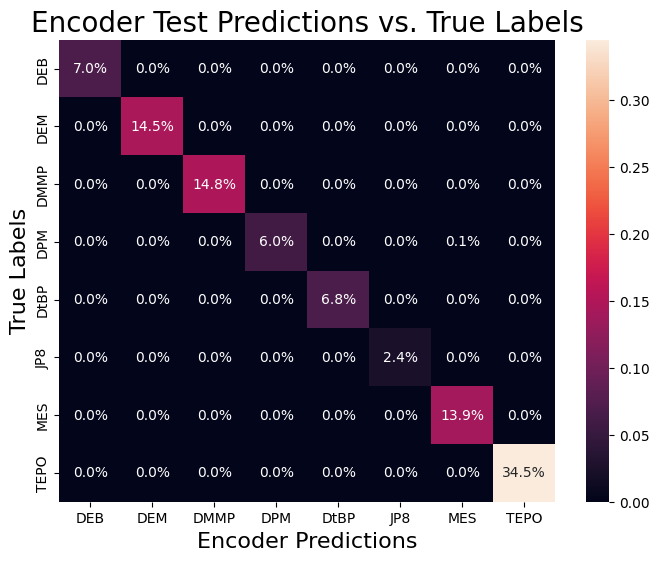

In [ ]:
# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    # test_cm, annot=True, cbar=True, 
    test_cm/np.sum(test_cm), annot=True, cbar=True, fmt='.1%',
    xticklabels=sorted_chem_names, yticklabels=sorted_chem_names
    )

plt.title('Encoder Test Predictions vs. True Labels', fontsize=20)
plt.xlabel('Encoder Predictions', fontsize=16)
plt.ylabel('True Labels', fontsize=16)
plt.show()

In [ ]:
encoder_criterion = nn.MSELoss()

val_dataset = DataLoader(
    TensorDataset(
        val_spectra_tensor, 
        val_chem_encodings_tensor, 
        val_chem_encodings_tensor,
        val_spectra_indices_tensor,
        ), 
        batch_size=best_hyperparams['batch_size'], 
        shuffle=True
        )

val_predicted_embeddings, val_output_name_encodings, val_average_loss, val_input_spectra_indices = predict_embeddings(val_dataset, best_model, device, encoder_criterion)

In [ ]:
# print(predicted_embeddings[0][2])
# print(output_name_encodings[0][2])

tensor([-6.1927e-04,  1.0037e+00, -6.0353e-04, -2.0185e-04,  3.4825e-04,
        -1.2604e-03, -3.5575e-05,  4.6582e-04], device='cuda:1')
tensor([0., 1., 0., 0., 0., 0., 0., 0.], device='cuda:1')


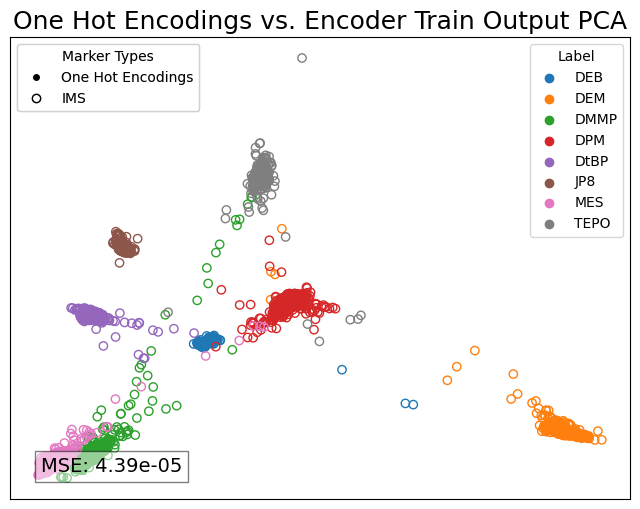

In [ ]:
encoder_criterion = nn.MSELoss()
batch_size=64
plot_pca(
    train_data, batch_size, best_model, device, 
    encoder_criterion, sorted_chem_names, all_true_encodings, 
    all_true_encodings, 'Train', log_wandb = False, embedding_type='One Hot Encodings'
    )

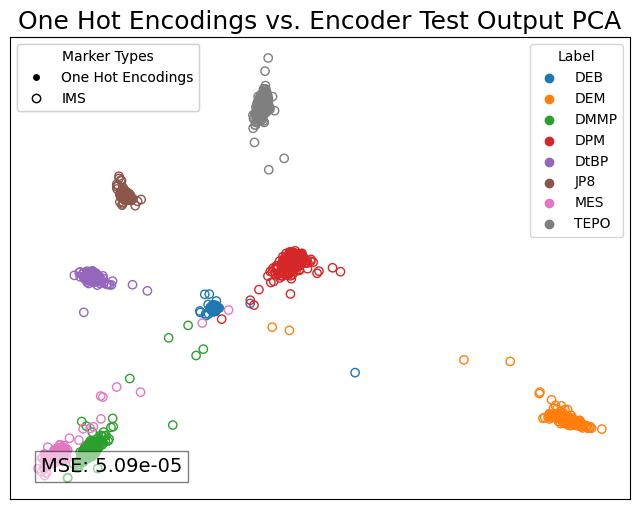

In [ ]:
plot_pca(
    test_data, batch_size, best_model, device, 
    encoder_criterion, sorted_chem_names, all_true_encodings, 
    all_true_encodings, 'Test', log_wandb = False, embedding_type='One Hot Encodings'
    )